# Food Time Delivery Prediction

<p align=center>
  <img src="https://img.freepik.com/vetores-premium/encomende-por-telefone-e-receba-a-comida-na-porta_23-2148555891.jpg?w=2000" width="60%">
</p>

Forecasting the delivery duration of an order poses a formidable challenge for any food delivery service. Among the most effective methodologies for anticipating delivery time is to assess the geographical span between the order's pickup location and its intended destination. This information is then utilized to predict the delivery time, drawing from historical data regarding the time taken by delivery partners to fulfill orders of comparable distances in the past.

Time delivery prediction typically falls under the realm of regression modeling. Regression is a type of supervised machine learning where the goal is to predict a continuous numeric output based on input features. In the context of time delivery prediction, you're aiming to predict a continuous variable (the time taken for delivery) based on various input features such as delivery person attributes, location coordinates, order type, vehicle type, etc.

There are various regression techniques available to construct a time delivery prediction model, including:

**Linear Regression**: Linear regression models assume a linear relationship between input features and the target variable. This approach is ideal when the relationship is roughly linear.

**Random Forest Regression**: Random forest is an ensemble method that amalgamates multiple decision trees for predictions. It excels at capturing non-linear relationships and feature interactions.

**Gradient Boosting Regression**: Gradient boosting assembles decision trees sequentially to rectify the errors of previous trees. It's notably effective for predictive tasks.

**Support Vector Regression (SVR)**: SVR is rooted in support vector machines and shines when dealing with non-linear patterns in data.

## Packages and data import


In [5]:
!pip install kaggle

# Move the uploaded kaggle.json to the proper location and set the required permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d 'bhanupratapbiswas/food-delivery-time-prediction-case-study'

 86%|████████████████████████████████▌     | 3.00M/3.50M [00:01<00:00, 3.58MB/s]
100%|██████████████████████████████████████| 3.50M/3.50M [00:01<00:00, 3.35MB/s]


In [7]:
import zipfile

with zipfile.ZipFile('food-delivery-time-prediction-case-study.zip', 'r') as zip_ref:
    zip_ref.extractall('data_directory')

In [50]:
#For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# For processing data
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For build ML regression model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV

In [14]:
df = pd.read_excel('data_directory/Food Delivery Time Prediction Case Study.xlsx')

df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


## Informations about the data

In [15]:
def data_info(df):
    num_entries, num_vars = df.shape
    feature_names = df.columns.values
    variable_types = df.dtypes
    unique_values = df.nunique().sort_values(ascending=False)
    max_missing = df.isnull().sum().max()
    missing_percentage = (df.isnull().sum() * 100 / num_entries).sort_values(ascending=False)

    print(f'Number of entries (rows): {num_entries}')
    print(f'\nNumber of variables (columns): {num_vars}')
    print(f'\nFeature names:\n{feature_names}')
    print(f'\nVariable Types (by column)\n{variable_types}')
    print(f'\nUnique values (by column):\n{unique_values}')
    print(f'\nMissing data (total): {max_missing}')
    print(f'\nPercentage of missing values (by column):\n{missing_percentage}')

data_info(df)

Number of entries (rows): 45593

Number of variables (columns): 11

Feature names:
['ID' 'Delivery_person_ID' 'Delivery_person_Age' 'Delivery_person_Ratings'
 'Restaurant_latitude' 'Restaurant_longitude' 'Delivery_location_latitude'
 'Delivery_location_longitude' 'Type_of_order' 'Type_of_vehicle'
 'Time_taken(min)']

Variable Types (by column)
ID                              object
Delivery_person_ID              object
Delivery_person_Age              int64
Delivery_person_Ratings        float64
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Type_of_order                   object
Type_of_vehicle                 object
Time_taken(min)                  int64
dtype: object

Unique values (by column):
ID                             45355
Delivery_location_latitude      4373
Delivery_location_longitude     4373
Delivery_person_ID              1320
Restaurant_latitude              65

In [16]:
df.Type_of_order.unique()

array(['Snack ', 'Drinks ', 'Buffet ', 'Meal '], dtype=object)

In [17]:
df.Type_of_vehicle.unique()

array(['motorcycle ', 'scooter ', 'electric_scooter ', 'bicycle '],
      dtype=object)

`ID`: A unique identifier for each delivery record.

`Delivery_person_ID`: A unique identifier for the delivery person responsible for the delivery.

`Delivery_person_Age`: The age of the delivery person, indicating how old they are.

`Delivery_person_Ratings`: The ratings or feedback received by the delivery person from customers, reflecting their service quality.

`Restaurant_latitude`: The latitude coordinate of the restaurant where the order is prepared.

`Restaurant_longitude`: The longitude coordinate of the restaurant where the order is prepared.

`Delivery_location_latitude`: The latitude coordinate of the delivery location where the order is to be delivered.

`Delivery_location_longitude`: The longitude coordinate of the delivery location where the order is to be delivered.

`Type_of_order`: The category or type of the order, which are `'Snack ', 'Drinks ', 'Buffet ', 'Meal '`.

`Type_of_vehicle`: The type of vehicle used for the delivery, indicating if it's `'motorcycle', 'scooter', 'electric_scooter', 'bicycle'`.

`Time_taken(min)`: The time taken to complete the delivery, measured in minutes. The variable target.

In [18]:
df.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min)
count,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000
mean,29.544075,4.632367,17.017729,70.231332,17.465186,70.845702,26.294607
std,5.696793,0.327708,8.185109,22.883647,7.335122,21.118812,9.383806
min,15.000000,1.000000,-30.905562,-88.366217,0.010000,0.010000,10.000000
25%,25.000000,4.600000,12.933284,73.170000,12.988453,73.280000,19.000000
50%,29.000000,4.700000,18.546947,75.898497,18.633934,76.002574,26.000000
75%,34.000000,4.800000,22.728163,78.044095,22.785049,78.107044,32.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,54.000000


About the numerical features:

* The maximum age of a delivery person is 50 and the mean is arount 29 years old and the minimun are 15.

* The delivery person rantings goes froom 1 to 6.

* The maximim time (in min) of a delivery is 54 and the minimum time is 10.

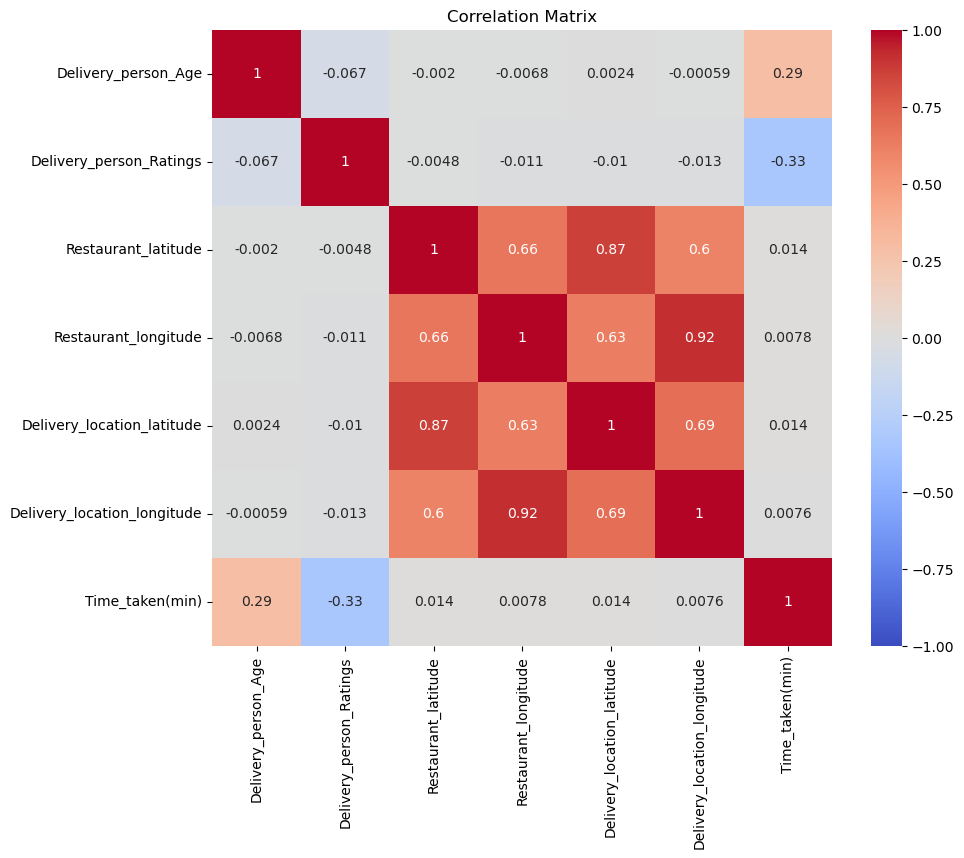

In [19]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Regarding the correlation matrix, it highlights the correlations between `Time_taken(min)` and `Delivery_person_Age`, as well as `Delivery_person_Ratings`.

## Feature engineering and new informations

To advance the project, several DataFrame adjustments are required. Two additional columns will be introduced to capture pertinent information. The first column will reflect the travel distance between the restaurant and the customer, while the second column will represent the speed associated with each vehicle type.

For improved DataFrame organization, the `ID` and `Delivery_person_ID` columns will be eliminated. Initially, these columns do not contribute to the construction of the machine learning model.

Revisions in the DataFrame structure will facilitate a streamlined approach towards enhancing the model's effectiveness.


In [20]:
# backup
df_new = df.copy()

In [21]:
# List of columns to be deleted
columns_to_delete = ['ID', 'Delivery_person_ID']

# Drop the specified columns
df_new = df_new.drop(columns=columns_to_delete)

df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


In [22]:
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = 6371 * c  # Earth's radius in kilometers
    return distance

# Calculate distances and create a new column in the DataFrame
df_new['distance'] = df_new.apply(lambda row: haversine_distance(row['Restaurant_latitude'], row['Restaurant_longitude'], row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)

# Print the DataFrame with distances
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),distance
0,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,3.025149
1,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33,20.183530
2,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26,1.552758
3,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21,7.790401
4,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30,6.210138


In [23]:
df_new['Time_taken(hr)'] = df_new['Time_taken(min)']/60
df_new['speed'] = df_new['distance']/df_new['Time_taken(hr)']

In [24]:
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),distance,Time_taken(hr),speed
0,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,3.025149,0.400000,7.562873
1,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33,20.183530,0.550000,36.697327
2,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26,1.552758,0.433333,3.583287
3,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21,7.790401,0.350000,22.258290
4,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30,6.210138,0.500000,12.420276


In [25]:
columns_to_drop = ['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Time_taken(hr)']

df_new = df_new.drop(columns=columns_to_drop )

df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Type_of_order,Type_of_vehicle,Time_taken(min),distance,speed
0,37,4.9,Snack,motorcycle,24,3.025149,7.562873
1,34,4.5,Snack,scooter,33,20.183530,36.697327
2,23,4.4,Drinks,motorcycle,26,1.552758,3.583287
3,38,4.7,Buffet,motorcycle,21,7.790401,22.258290
4,32,4.6,Snack,scooter,30,6.210138,12.420276


In [26]:
df_new[['distance', 'speed']].describe()

,distance,speed
count,45593.000000,45593.000000
mean,99.303911,262.045334
std,1099.731281,3147.743785
min,1.465067,1.696010
25%,4.663493,12.581569
50%,9.264281,20.725588
75%,13.763977,31.595710
max,19692.674606,107403.910650


The introduction of new features has unveiled certain data inconsistencies. For instance, within the distance column, while the maximum distance reaches 19692.67 km, the fourth quartile rests at 13.76 km. A parallel issue arises within the speed column, with a fourth quartile value of 31.59, yet an exceptional maximum value of 107403.91. These disparities warrant further investigation to ascertain potential anomalies or errors in the dataset.

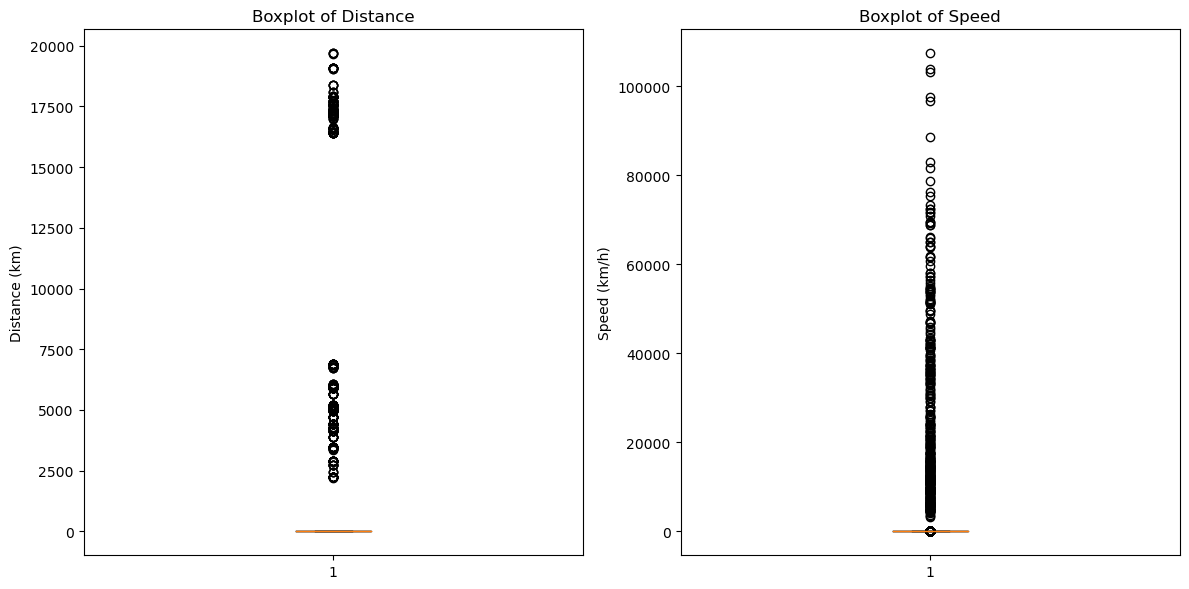

In [27]:
# Create separate boxplots for 'distance' and 'speed'
plt.figure(figsize=(12, 6))

# Boxplot for 'distance'
plt.subplot(1, 2, 1)  # Subplot 1
plt.boxplot(df_new['distance'])
plt.title('Boxplot of Distance')
plt.ylabel('Distance (km)')

# Boxplot for 'speed'
plt.subplot(1, 2, 2)  # Subplot 2
plt.boxplot(df_new['speed'])
plt.title('Boxplot of Speed')
plt.ylabel('Speed (km/h)')

plt.tight_layout()  # Adjust layout
plt.show()

In [28]:
def outlier_boundary(dataset, column_list):
    # Iterate over the columns from the list passed as an argument
    for column in column_list:
        # Check if the column exists in the dataset
        if column in dataset:
            # Calculate summary statistics for the column
            desc = dataset[column].describe()
            # Retrieve the first quartile (Q1)
            Q1 = desc["25%"]
            # Retrieve the third quartile (Q3)
            Q3 = desc["75%"]
            # Calculate the interquartile range (IQR)
            IQR = Q3 - Q1
            # Calculate the upper and lower boundaries
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            # Print the upper and lower boundaries for the column
            print(f"The upper boundary for column {column} is {upper} and the lower boundary is {lower}.")

# Application
outlier_boundary(df_new, ['distance', 'speed'])

The upper boundary for column distance is 27.414703351191108 and the lower boundary is -8.987232986844802.
The upper boundary for column speed is 60.11692182808743 and the lower boundary is -15.939642264924677.


In [29]:
cols_outliers = ['distance', 'speed']

# Loop for each feature
for feature in cols_outliers:
    Q1 = df_new[feature].quantile(q=0.25)  # Define the first quartile
    Q3 = df_new[feature].quantile(q=0.75)  # Define the third quartile
    IQR = Q3 - Q1  # Define the interquartile range
    Upper_Limit = Q3 + 1.5 * IQR  # Define the Upper Limit
    Lower_Limit = Q1 - 1.5 * IQR  # Define the Lower Limit

    # Select only rows without outliers
    df_new = df_new.loc[(df_new[feature] >= Lower_Limit) & (df_new[feature] <= Upper_Limit)]

    # Reset the index
    df_new = df_new.reset_index(drop=True)

In [30]:
df_new[['distance', 'speed']].describe()

,distance,speed
count,43585.000000,43585.000000
mean,9.435049,22.060387
std,5.452926,12.720305
min,1.465067,1.696010
25%,4.657347,12.174454
50%,9.121874,19.948650
75%,13.407034,29.828812
max,20.969489,59.092155


Upon data adjustment, notable observations arise. The maximum distance value now hovers at approximately 21 km, while the minimum rests at 1.46 km. Similarly, within the speed feature, the maximum recorded value is 59 km/hr, while the minimum registers around 1.7 km/hr. These refined ranges suggest that the dataset is now exhibiting a more coherent and accurate representation of the underlying information.

## Preprocessing the data

We are now entering the preprocessing phase to prepare our features before constructing the machine learning model.

The preprocessing steps involve:

1. **Scaling Numerical Features:** To ensure that our model performs optimally, we will apply feature scaling to `Delivery_person_Age` using `StandardScaler` and to `Delivery_person_Ratings` using `MinMaxScaler`. This will standardize the age values and scale the ratings within a specific range to make them compatible with the model's requirements.

2. **Encoding Categorical Features:** Additionally, we will use `OneHotEncoder` to encode the categorical variables `Type_of_order` and `Type_of_vehicle`. This transformation will convert these categorical variables into numerical format, creating distinct binary columns for each category. This way, the model can effectively use these features during training.

By conducting these preprocessing steps, we aim to establish a solid foundation for building an effective machine learning model that capitalizes on the inherent characteristics of our features.

In [31]:
# preprocessing numerical features

std_scaler = StandardScaler()
min_max = MinMaxScaler()

df_new['std_Delivery_person_Age'] = std_scaler.fit_transform(df_new['Delivery_person_Age'].values.reshape(-1,1))
df_new['std_Delivery_person_Ratings'] = min_max.fit_transform(df_new['Delivery_person_Ratings'].values.reshape(-1,1))

df_new.drop(['std_Delivery_person_Age', 'Delivery_person_Ratings'], axis=1, inplace=True)

In [32]:
df_new.head()

,Delivery_person_Age,Type_of_order,Type_of_vehicle,Time_taken(min),distance,speed,std_Delivery_person_Ratings
0,37,Snack,motorcycle,24,3.025149,7.562873,0.78
1,34,Snack,scooter,33,20.183530,36.697327,0.70
2,23,Drinks,motorcycle,26,1.552758,3.583287,0.68
3,38,Buffet,motorcycle,21,7.790401,22.258290,0.74
4,32,Snack,scooter,30,6.210138,12.420276,0.72


In [33]:
# preprocessing categorical features

ohe = OneHotEncoder()

cols_to_onehot = ['Type_of_order', 'Type_of_vehicle']

df_encoded = ohe.fit_transform(df_new[cols_to_onehot])
df_encoded = pd.DataFrame(df_encoded.toarray(), columns=ohe.get_feature_names_out(cols_to_onehot))

# Drop the original categorical columns from df_new
df_new.drop(columns=cols_to_onehot, inplace=True)

# Concatenate the encoded DataFrame to df_new
df_new = pd.concat([df_new.reset_index(drop=True), df_encoded], axis=1)

In [34]:
df_new.head()

,Delivery_person_Age,Time_taken(min),distance,speed,std_Delivery_person_Ratings,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,Type_of_vehicle_bicycle,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter
0,37,24,3.025149,7.562873,0.78,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,34,33,20.183530,36.697327,0.70,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,23,26,1.552758,3.583287,0.68,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,38,21,7.790401,22.258290,0.74,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,32,30,6.210138,12.420276,0.72,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [35]:
X = df_new.drop('Time_taken(min)', axis = 1)
y = df_new['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(X,y)

## Creating a Machine Learning Model



In [37]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(kernel='linear'),
    SVR(kernel='rbf'),
]

scoring = {
    'r2': 'r2',
    'neg_mean_absolute_error': make_scorer(mean_absolute_error),
    'neg_mean_squared_error': make_scorer(mean_squared_error),
}

for model in models:
    print(f"Model: {model.__class__.__name__}")
    scores = cross_validate(model, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring=scoring)

    r2_mean = np.mean(scores['test_r2'])
    mae_mean = np.mean(scores['test_neg_mean_absolute_error'])
    rmse_mean = np.mean(scores['test_neg_mean_squared_error'])

    print(f"R2: {r2_mean:.4f}")
    print(f"MAE: {mae_mean:.4f}")
    print(f"MSE: {rmse_mean:.4f}")
    print("-" * 30)

Model: LinearRegression
R2: 0.8120
MAE: 2.9569
MSE: 16.1735
------------------------------
Model: Ridge
R2: 0.8120
MAE: 2.9569
MSE: 16.1734
------------------------------
Model: Lasso
R2: 0.8040
MAE: 3.0053
MSE: 16.8641
------------------------------
Model: ElasticNet
R2: 0.8024
MAE: 3.0141
MSE: 16.9981
------------------------------
Model: RandomForestRegressor
R2: 0.9995
MAE: 0.0600
MSE: 0.0471
------------------------------
Model: GradientBoostingRegressor
R2: 0.9772
MAE: 1.0048
MSE: 1.9626
------------------------------
Model: SVR
R2: 0.8063
MAE: 2.8983
MSE: 16.6634
------------------------------
Model: SVR
R2: 0.9563
MAE: 0.9187
MSE: 3.7591
------------------------------


The RandomForest Regressor emerges as the optimal model, showcasing superior performance across various evaluation metrics.

Visualizing the learning curve post cross-validation helps assess bias, variance, data sufficiency, and model performance. It's a useful tool to detect underfitting or overfitting, understand generalization, and identify areas for optimization.

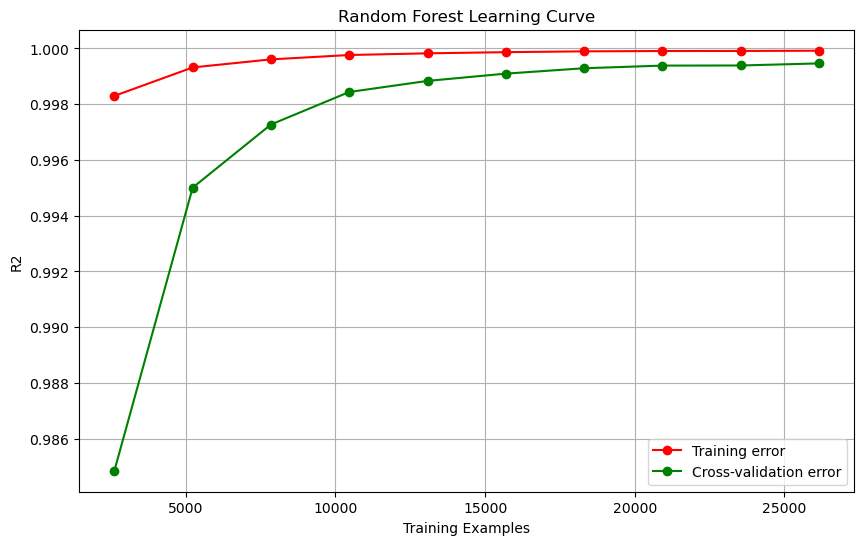

In [55]:
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("R2")
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation error")
    plt.legend(loc="best")
    plt.show()


model = RandomForestRegressor()
plot_learning_curve(model, X_train, y_train, "Random Forest Learning Curve")

### Tuning hyperparameters

The R-squared (R2) value is near 1, it indicates that the model is explaining a large portion of the variance in the target variable. In other words, the model's predictions are closely aligned with the actual values. However, even if the R2 value is high, it's still important to consider hyperparameter tuning and other aspects of model evaluation:

**Optimal Performance**: Despite an R2 close to 1 indicating favorable outcomes, exploring different hyperparameter configurations could potentially yield further advancements in model efficacy.

**Generalization**: Upholding the model's capacity to generalize across new, unseen data is pivotal. Hyperparameter refinement aids in averting overfitting and enhances adaptability to diverse datasets.

**Future Data**: Your current dataset might harmonize well with existing hyperparameters. However, the real-world data landscape varies, and hyperparameter fine-tuning enhances model robustness for evolving scenarios.

**Changing Data**: Over time, shifts in your dataset may render current hyperparameters suboptimal. Regular hyperparameter adjustments enable your model to flexibly adapt to evolving data dynamics.

**Incremental Enhancement**: Even marginal improvements resulting from hyperparameter tuning can confer gains in predictive accuracy and overall model stability.

**Exploratory Insights**: Delving into hyperparameters provides a deeper understanding of your model's behavior under diverse configurations, valuable for interpreting its intrinsic characteristics.

**New Data Introduction**: When integrating new data, assessing whether prevailing hyperparameters still yield optimal outcomes is a recommended practice.

In [56]:
# Define the hyperparameters and their potential values
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest Regressor model
model = RandomForestRegressor()

# Initialize GridSearchCV with the model, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model R2:", r2_mean)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Model R2: 0.9563012556417828


It appears that the default parameters for Random Forest Regression yield the most favorable results.

### Testing the final model

In [57]:
#instantiating the final model
model_final = RandomForestRegressor()
model_final.fit(X_train, y_train)

RandomForestRegressor()

In [59]:
# Make predictions
y_train_pred = model_final.predict(X_train)
y_test_pred = model_final.predict(X_test)

In [60]:
# Metrics for the final model
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

msle_train = mean_squared_log_error(y_train, y_train_pred)
msle_test = mean_squared_log_error(y_test, y_test_pred)

print(f"Training R2: {r2_train: .4f}")
print(f"Testing R2: {r2_test: .4f}")
print(f"Training MAE: {mae_train: .4f}")
print(f"Testing MAE: {mae_test: .4f}")
print(f"Training RMSE: {rmse_train: .4f}")
print(f"Testing RMSE: {rmse_test: .4f}")

Training R2:  0.9999
Testing R2:  0.9993
Training MAE:  0.0199
Testing MAE:  0.0538
Training RMSE:  0.0759
Testing RMSE:  0.2419


### Saving the model

In [79]:
import joblib

# Save the model to a file
model_filename = 'trained_model.joblib'
joblib.dump(model_final, model_filename)

['trained_model.joblib']

## Conclusion

In conclusion, the Food Time Delivery Prediction project has adeptly navigated through crucial stages to construct an efficient predictive model. The process is initiated by engineering significant features like distance and speed, pinpointing influential attributes impacting delivery times. Subsequent phases focused on meticulous data refinement, addressing inconsistencies, and shaping a robust dataset.

Preprocessing surfaced as a pivotal juncture, encompassing vital tasks like feature scaling and categorical variable encoding, all aimed at enhancing the model's performance. Cross-validation emerged as a crucial contributor, rigorously assessing the model's capacity to generalize across varied datasets. It led to the RandomForestRegressor, which demonstrated the most promising metrics for this particular dataset. Subsequently, the journey took us through the intricate process of hyperparameter tuning, refining the model's configuration to achieve the utmost predictive prowess. Interestingly, the culmination of these efforts led to the confirmation that the default configuration of RandomForestRegressor yielded the optimal outcome.

Ultimately, the project culminated in the selection of RandomForestRegressor as the final model. Its superior performance in terms of Mean Squared Error (MSE) and R-squared (R2) demonstrated its ability to accurately predict delivery times. The successful journey through feature engineering, data cleaning, preprocessing, cross-validation, hyperparameter tuning, and model selection reinforces the robustness of the constructed Food Time Delivery Prediction model.
